<a href="https://colab.research.google.com/github/ShayHXY1017/Python-for-Public-Policy-Final-Project/blob/main/EU_ETS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Assessing the Effectiveness of the EU Emissions Trading System (ETS)

**Author:** Shay Hao

**UNI** xh2673  

**Course:** Python for Public Policy  

**Date:** Oct. 25th, 2025


# Part 1 Introduction of the EU ETS

The European Union Emissions Trading System (EU ETS) is the cornerstone of the EU’s climate policy and the world’s first major carbon market. Introduced in 2005, the ETS aims to reduce greenhouse gas emissions by setting a cap on the total amount of emissions allowed from covered installations and letting firms trade emission allowances. Companies that emit less can sell their surplus permits to others, creating a market-based incentive to reduce emissions efficiently.

During its early years, the ETS faced several challenges, including overallocation of permits and low carbon prices that limited its environmental impact. Substantial reforms in later phases, especially after 2013, strengthened the system by introducing a single EU-wide cap, auctioning a greater share of allowances, and creating a Market Stability Reserve to manage price volatility. These improvements coincided with a stronger and more stable carbon price.

Evaluating whether these changes have translated into measurable emission reductions remains an essential policy question. By analyzing historical data on carbon emissions from two sectors, Electricity (ETS-covered) and Transportation (non-ETS). This notebook aims to test whether emissions in the ETS-covered sector have declined faster than in the non-covered one.

# Part 2 Research Question & Data
**Research Question:** Has the EU ETS effectively reduced CO₂ emissions in covered sectors, particularly electricity and heat production, compared with non-covered sectors such as transportation?

The dataset contains annual CO₂ emissions for EU countries from 1990 to 2023, separated into two main sectors: Electricity and Transportation. It also includes an aggregated “EU-27” entry representing total emissions across member states. This enables both country-level and EU-level assessments.

The analysis proceeds through several stages: data cleaning, visualization of emission trajectories, estimation of linear trends (slopes), pre-/post-2005 comparisons, and a paired t-test to determine whether emissions fell more rapidly in ETS sectors. All steps are implemented in Python using the pandas, matplotlib, seaborn, and scipy libraries.



# Part 3 Data Processing

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [ ]:
# csv file uploaded into google colab for easier read
# original file can be found in github repository as well
raw = pd.read_csv('/Heat & Transportation Emission Data.csv', encoding='utf-16', sep='\t')
print(raw.head())
print(raw.columns)

                                        Sector Name  Gas  Country  \
0  1.A.1.a - Public Electricity and Heat Production  CO₂  Austria   
1  1.A.1.a - Public Electricity and Heat Production  CO₂  Austria   
2  1.A.1.a - Public Electricity and Heat Production  CO₂  Austria   
3  1.A.1.a - Public Electricity and Heat Production  CO₂  Austria   
4  1.A.1.a - Public Electricity and Heat Production  CO₂  Austria   

   Year of Date           t  
0          1990  11,056,340  
1          1991  11,767,755  
2          1992   8,599,200  
3          1993   8,430,924  
4          1994   8,712,226  
Index(['Sector Name', 'Gas', 'Country', 'Year of Date', 't'], dtype='object')


In [ ]:
# rename columns and copy to a new df called emission
emission = raw[['Sector Name', 'Country', 'Year of Date', 't']].copy()
emission.columns = ['Sector', 'Country', 'Year', 'Emission']
print(emission.head())

                                             Sector  Country  Year    Emission
0  1.A.1.a - Public Electricity and Heat Production  Austria  1990  11,056,340
1  1.A.1.a - Public Electricity and Heat Production  Austria  1991  11,767,755
2  1.A.1.a - Public Electricity and Heat Production  Austria  1992   8,599,200
3  1.A.1.a - Public Electricity and Heat Production  Austria  1993   8,430,924
4  1.A.1.a - Public Electricity and Heat Production  Austria  1994   8,712,226


In [ ]:
# remove comma from emission column
emission['Emission'] = emission['Emission'].astype(str).str.replace(',', '').str.replace(' ', '')
emission['Emission'] = pd.to_numeric(emission['Emission'], errors='coerce')
np.dtype(emission['Emission'])
print(emission.head())

                                             Sector  Country  Year  Emission
0  1.A.1.a - Public Electricity and Heat Production  Austria  1990  11056340
1  1.A.1.a - Public Electricity and Heat Production  Austria  1991  11767755
2  1.A.1.a - Public Electricity and Heat Production  Austria  1992   8599200
3  1.A.1.a - Public Electricity and Heat Production  Austria  1993   8430924
4  1.A.1.a - Public Electricity and Heat Production  Austria  1994   8712226


In [ ]:
# simplify sector names
emission['Sector'] = emission['Sector'].str.lower()
emission['Sector'] = emission['Sector'].apply(lambda s:
    'Electricity' if 'electric' in s or 'heat' in s
    else ('Transportation' if 'transport' in s else 'Other')
)
print(emission.head())

        Sector  Country  Year  Emission
0  Electricity  Austria  1990  11056340
1  Electricity  Austria  1991  11767755
2  Electricity  Austria  1992   8599200
3  Electricity  Austria  1993   8430924
4  Electricity  Austria  1994   8712226


Electricity: slope = -14541943.46 per year (p = 0.000)
Transportation: slope = 3295200.38 per year (p = 0.000)


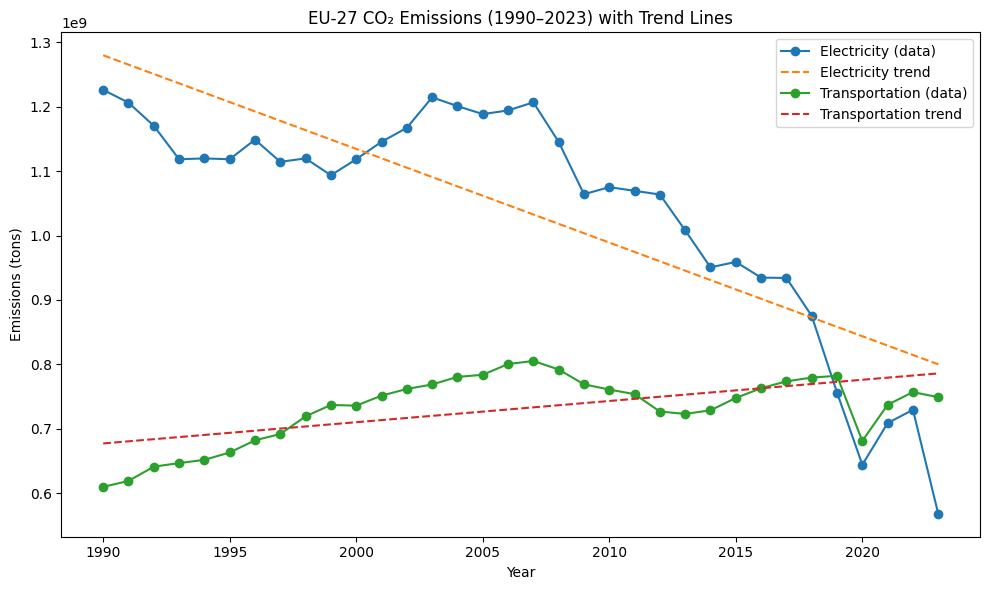

In [45]:
# dataset already contains aggregate data for eu as a whole
eu = emission[emission['Country'] == 'EU-27'].copy()
plt.figure(figsize=(10,6))

for sector in eu['Sector'].unique():
    series = eu[eu['Sector'] == sector].sort_values('Year')

    # Plot actual emission data
    plt.plot(series['Year'], series['Emission'], marker='o', label=f"{sector} (data)")

    # Add linear trend line
    if len(series) >= 2:
        slope, intercept, r, p, stderr = linregress(series['Year'], series['Emission'])
        fit_line = intercept + slope * series['Year']
        plt.plot(series['Year'], fit_line, linestyle='--', label=f"{sector} trend")
        print(f"{sector}: slope = {slope:.2f} per year (p = {p:.3f})")

plt.title("EU-27 CO₂ Emissions (1990–2023) with Trend Lines")
plt.xlabel("Year")
plt.ylabel("Emissions (tons)")
plt.legend()
plt.tight_layout()
plt.show()

In [48]:
pre = eu[eu['Year'] < 2005].groupby('Sector')['Emission'].mean().rename('Pre2005')
post = eu[eu['Year'] >= 2005].groupby('Sector')['Emission'].mean().rename('Post2005')
summary = pd.concat([pre, post], axis=1)
summary['Change'] = summary['Post2005'] - summary['Pre2005']
print(summary)

                     Pre2005      Post2005        Change
Sector                                                  
Electricity     1.152224e+09  9.513742e+08 -2.008494e+08
Transportation  6.973463e+08  7.586478e+08  6.130150e+07


Austria, Electricity: slope = -157012.61 per year (p = 0.000)
Austria, Transportation: slope = 232267.40 per year (p = 0.000)


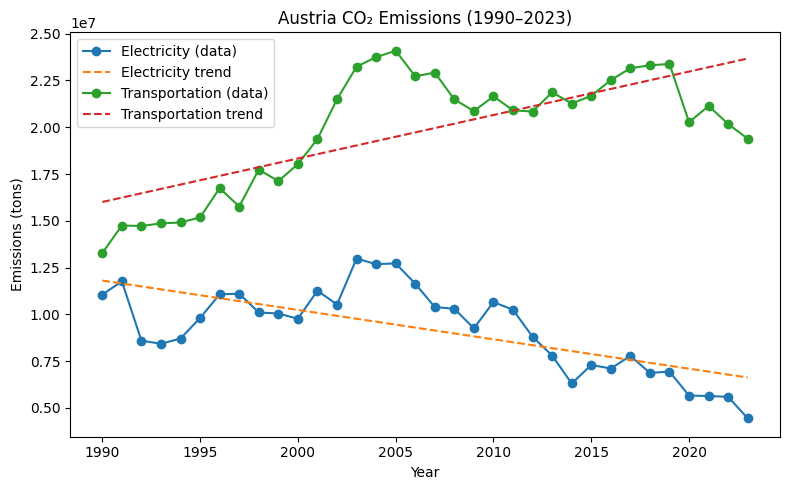

Belgium, Electricity: slope = -377667.99 per year (p = 0.000)
Belgium, Transportation: slope = 95346.21 per year (p = 0.005)


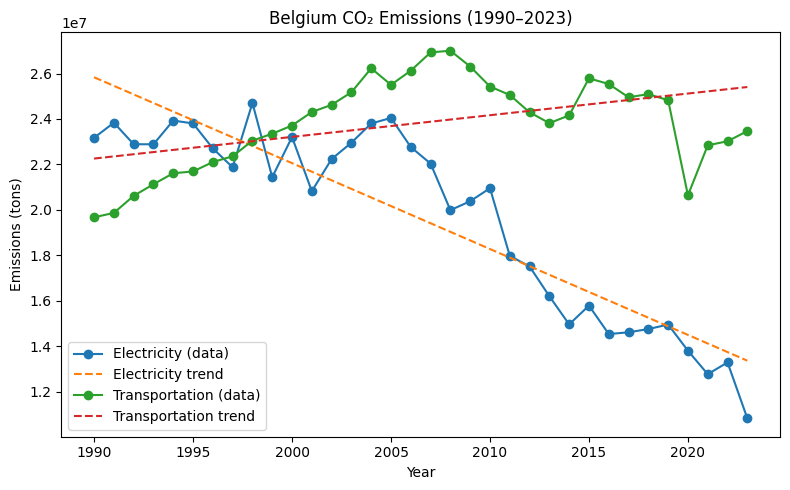

Bulgaria, Electricity: slope = -179291.68 per year (p = 0.011)
Bulgaria, Transportation: slope = 199663.37 per year (p = 0.000)


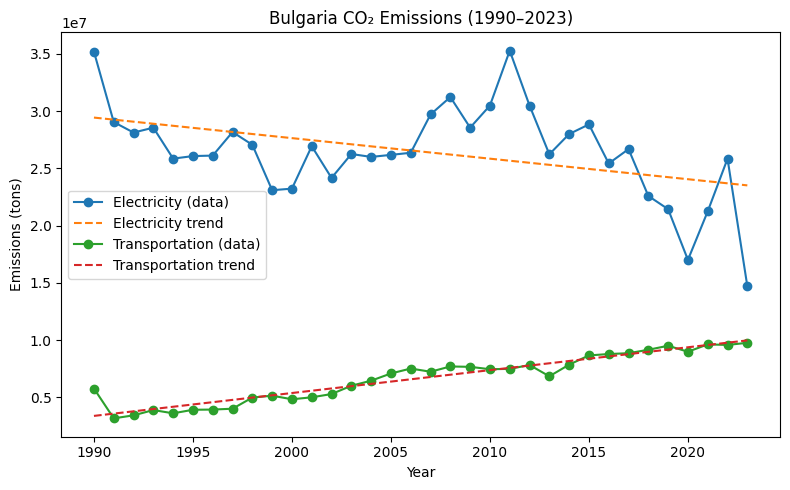

Croatia, Electricity: slope = -22592.06 per year (p = 0.172)
Croatia, Transportation: slope = 118874.39 per year (p = 0.000)


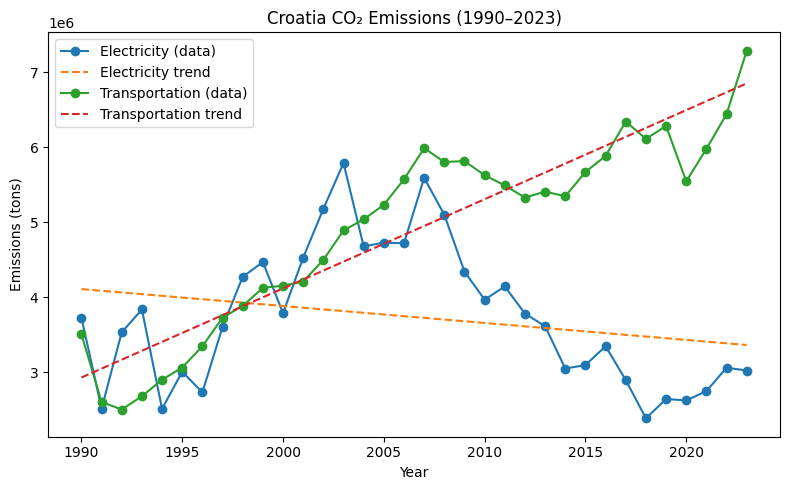

Cyprus, Electricity: slope = 41880.05 per year (p = 0.000)
Cyprus, Transportation: slope = 23825.99 per year (p = 0.000)


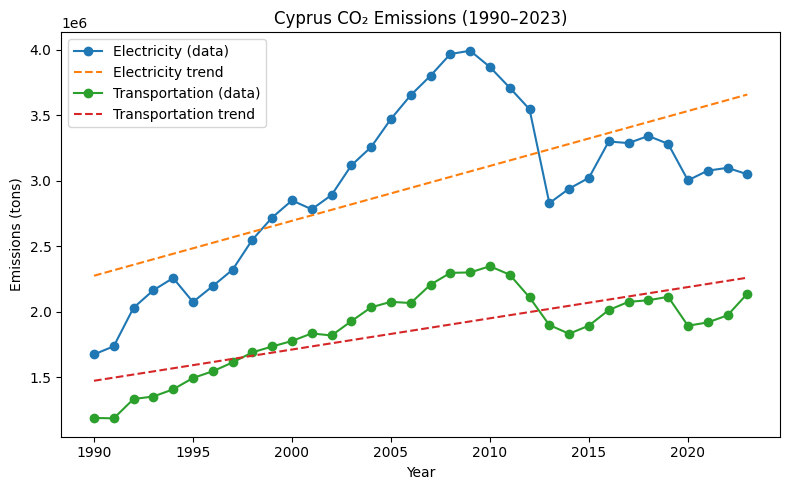

Czechia, Electricity: slope = -512631.47 per year (p = 0.000)
Czechia, Transportation: slope = 321555.96 per year (p = 0.000)


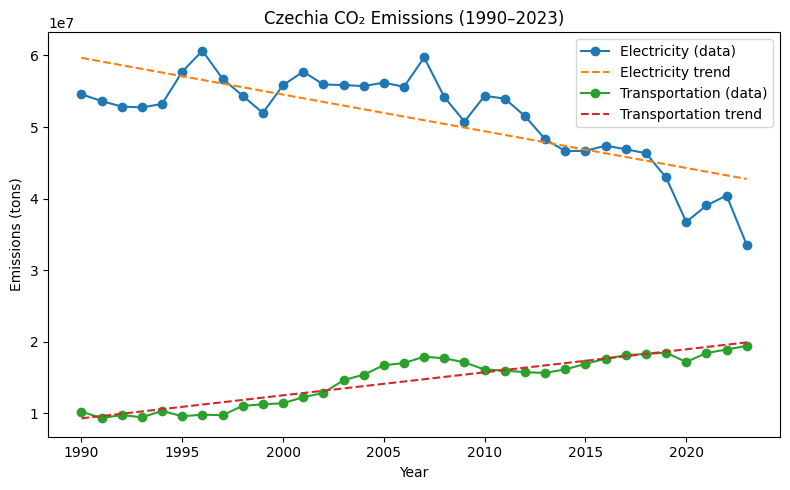

Denmark, Electricity: slope = -905943.64 per year (p = 0.000)
Denmark, Transportation: slope = 43955.02 per year (p = 0.003)


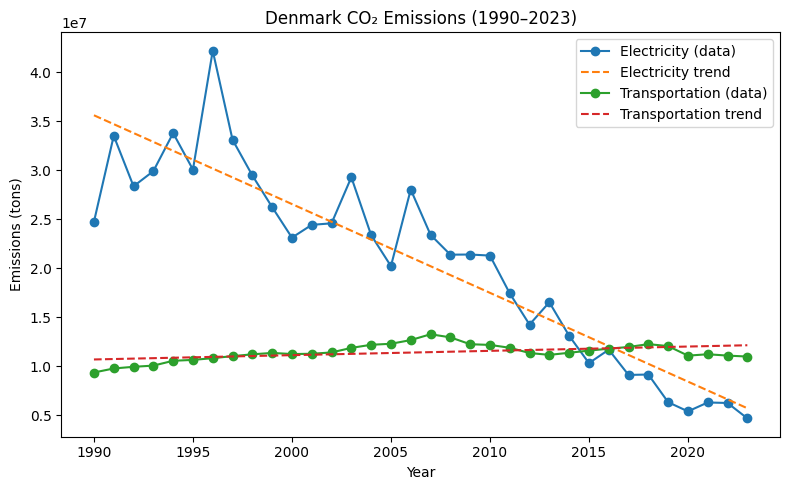

Estonia, Electricity: slope = -361379.77 per year (p = 0.000)
Estonia, Transportation: slope = 28924.22 per year (p = 0.000)


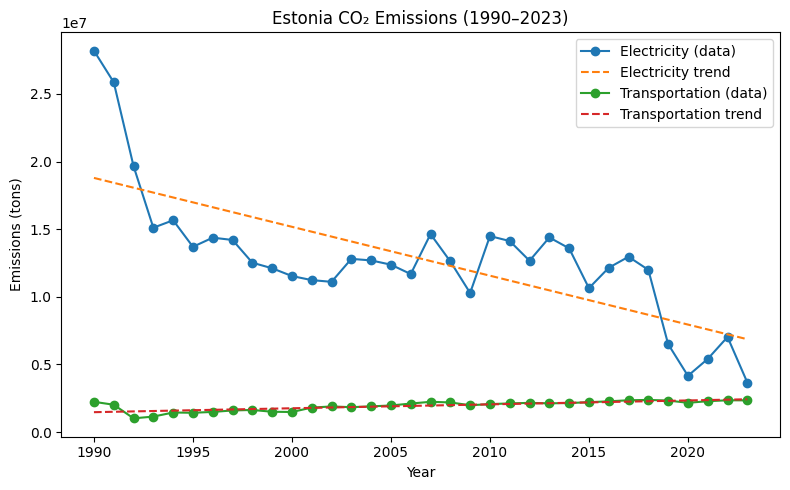

Finland, Electricity: slope = -280954.76 per year (p = 0.006)
Finland, Transportation: slope = -16144.19 per year (p = 0.265)


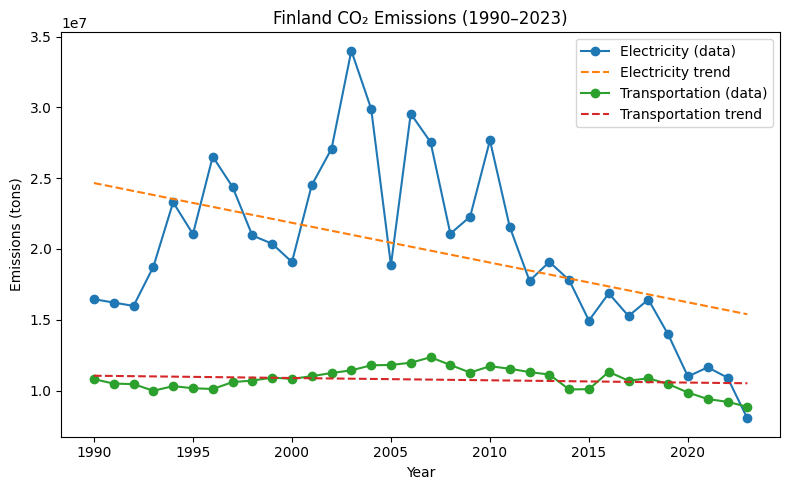

France, Electricity: slope = -407908.03 per year (p = 0.000)
France, Transportation: slope = -139343.07 per year (p = 0.234)


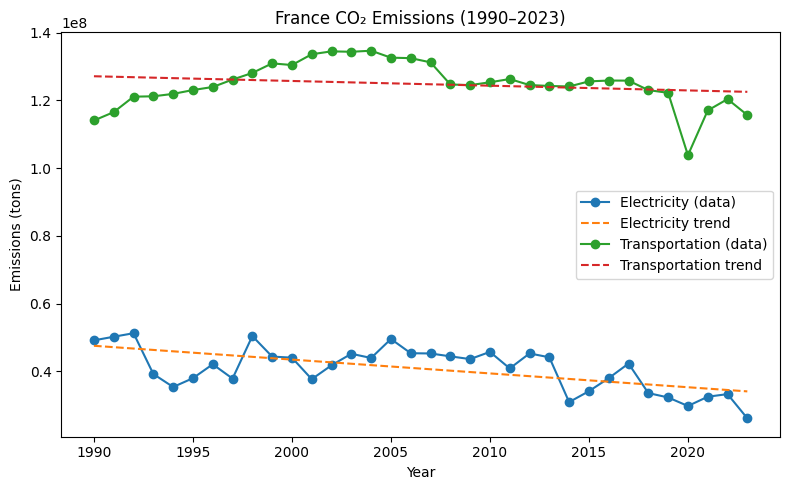

Germany, Electricity: slope = -3136357.76 per year (p = 0.000)
Germany, Transportation: slope = -658539.37 per year (p = 0.000)


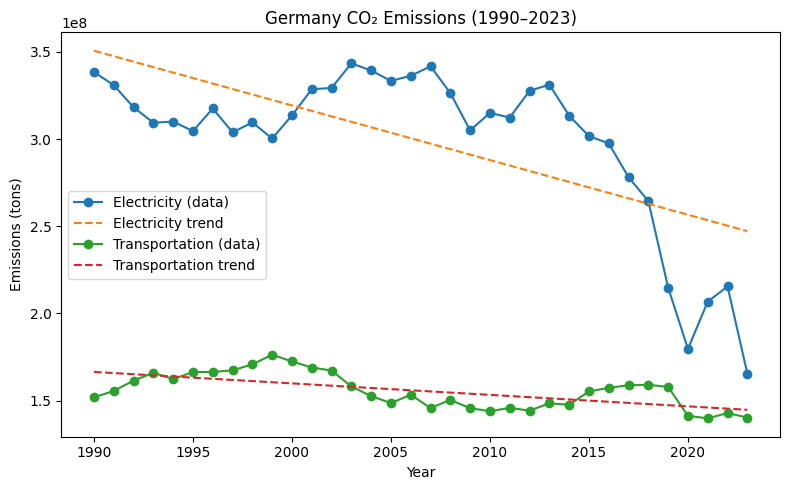

Greece, Electricity: slope = -635500.51 per year (p = 0.001)
Greece, Transportation: slope = 32484.97 per year (p = 0.438)


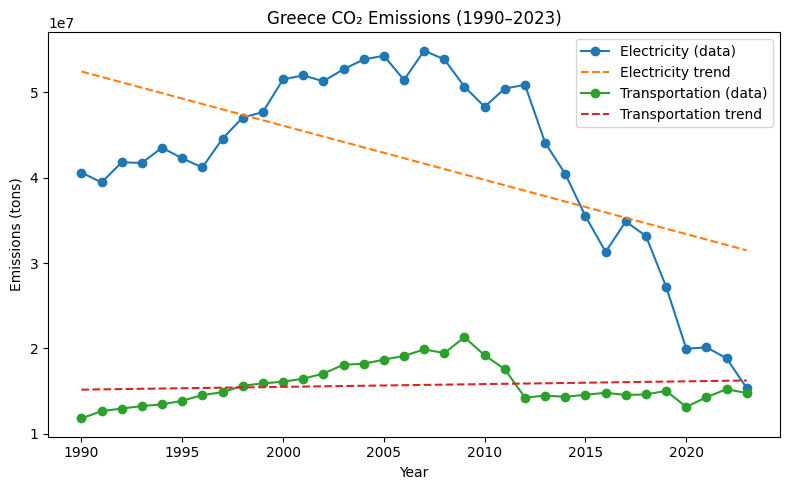

Hungary, Electricity: slope = -412052.42 per year (p = 0.000)
Hungary, Transportation: slope = 225284.89 per year (p = 0.000)


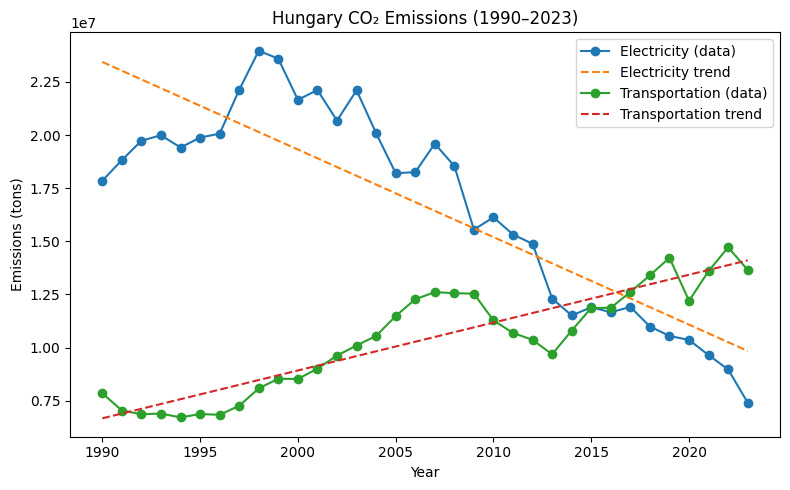

Iceland, Electricity: slope = -261.98 per year (p = 0.002)
Iceland, Transportation: slope = 13870.20 per year (p = 0.000)


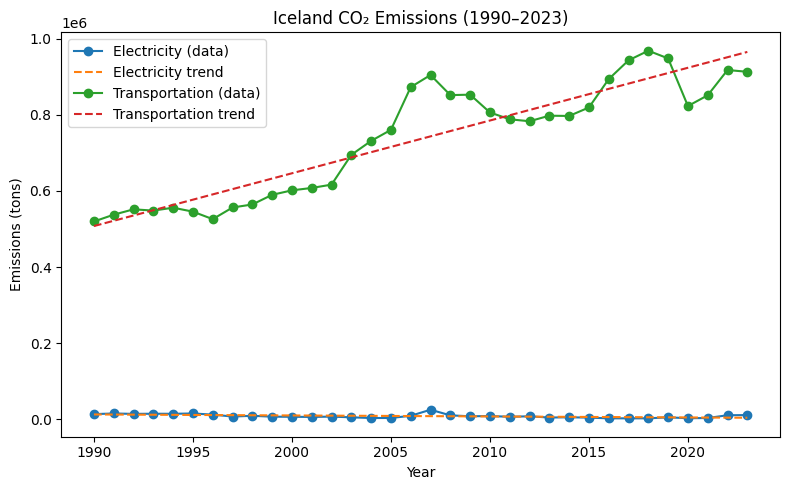

Ireland, Electricity: slope = -142478.72 per year (p = 0.000)
Ireland, Transportation: slope = 186998.17 per year (p = 0.000)


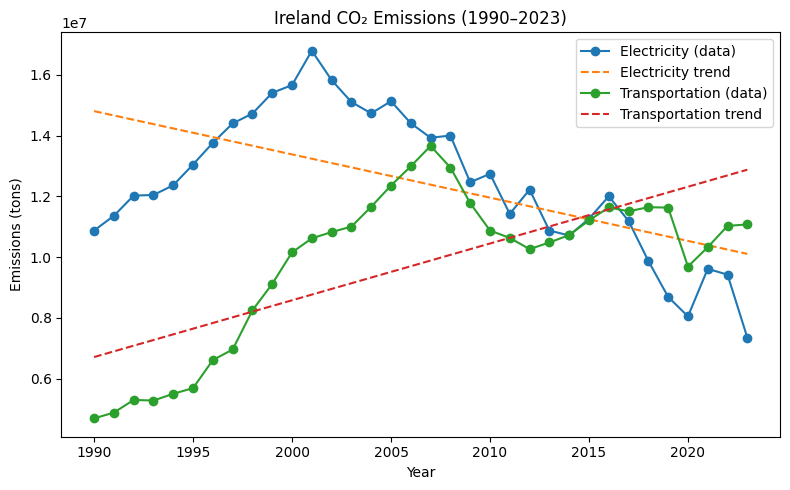

Italy, Electricity: slope = -1482996.21 per year (p = 0.000)
Italy, Transportation: slope = -310792.07 per year (p = 0.058)


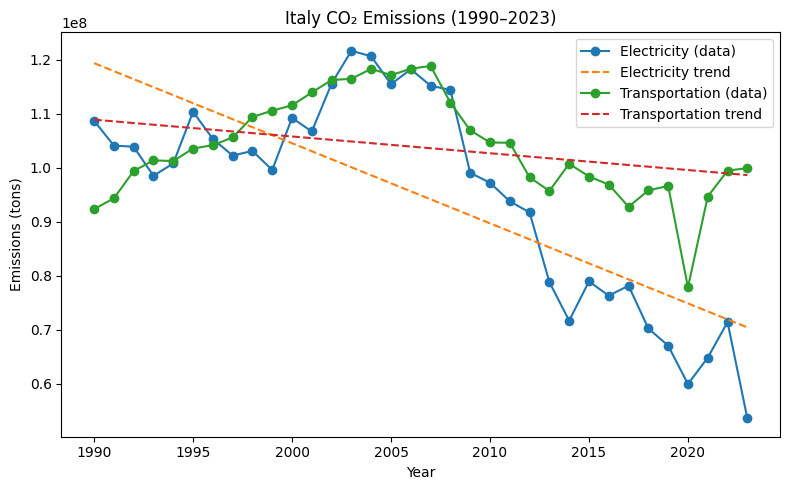

Latvia, Electricity: slope = -104928.50 per year (p = 0.000)
Latvia, Transportation: slope = 40051.62 per year (p = 0.000)


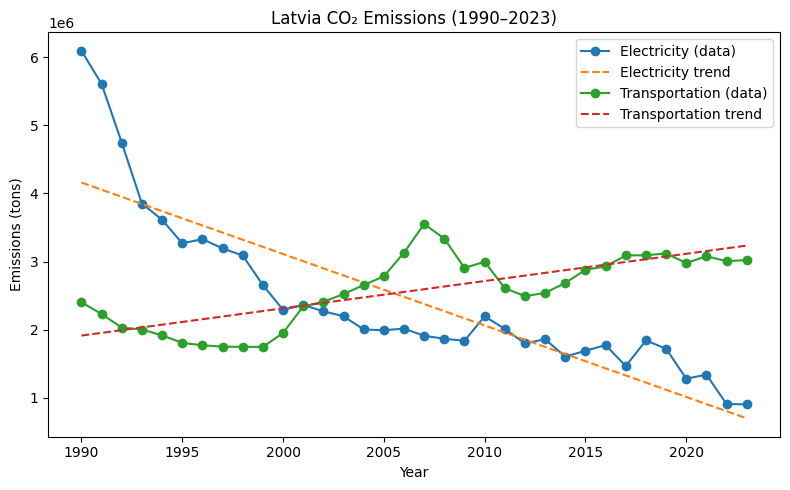

Lithuania, Electricity: slope = -248701.14 per year (p = 0.000)
Lithuania, Transportation: slope = 76441.14 per year (p = 0.000)


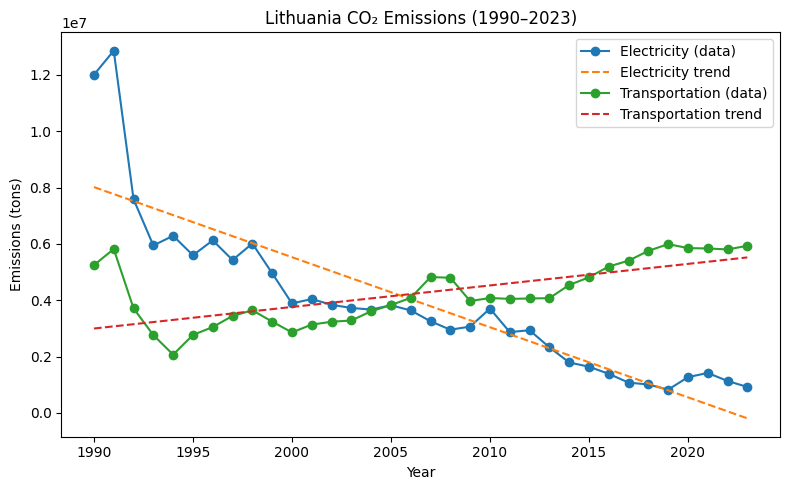

Luxembourg, Electricity: slope = 9556.47 per year (p = 0.246)
Luxembourg, Transportation: slope = 68834.48 per year (p = 0.002)


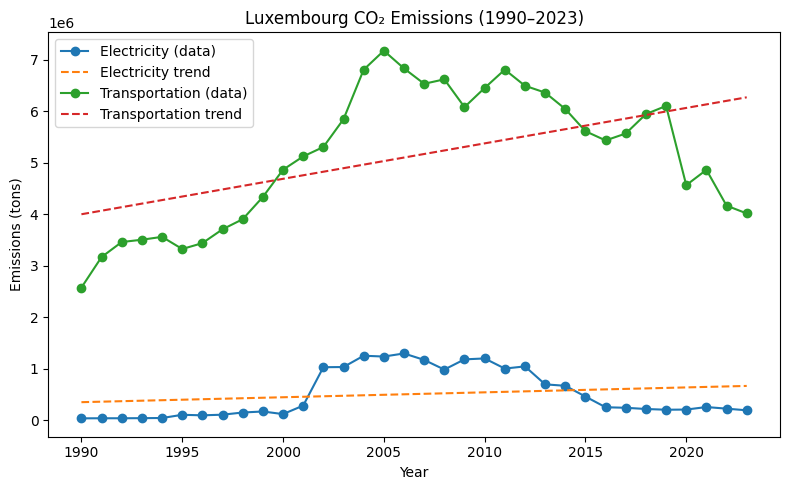

Malta, Electricity: slope = -32721.44 per year (p = 0.000)
Malta, Transportation: slope = 7041.95 per year (p = 0.000)


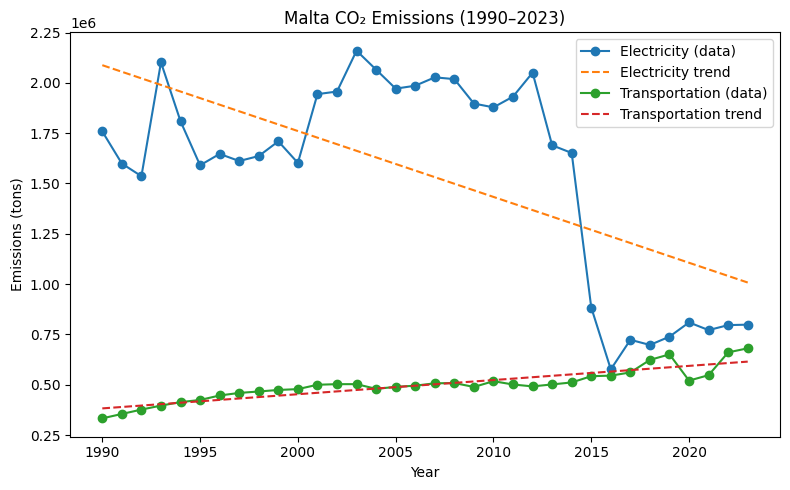

Netherlands, Electricity: slope = -158520.19 per year (p = 0.215)
Netherlands, Transportation: slope = -94782.42 per year (p = 0.072)


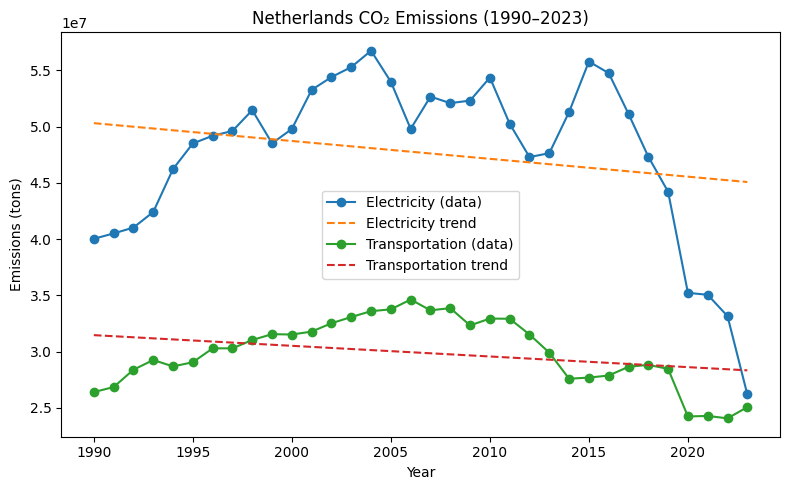

Norway, Electricity: slope = 43532.77 per year (p = 0.000)
Norway, Transportation: slope = 58559.95 per year (p = 0.000)


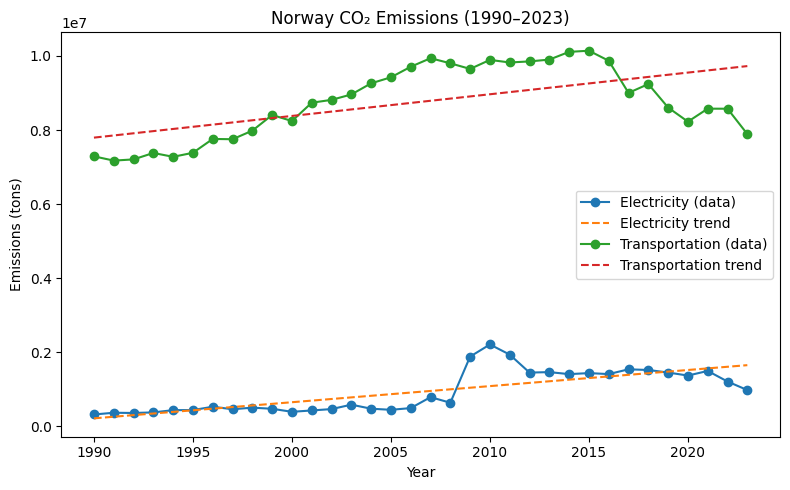

Poland, Electricity: slope = -2028074.81 per year (p = 0.000)
Poland, Transportation: slope = 1546398.24 per year (p = 0.000)


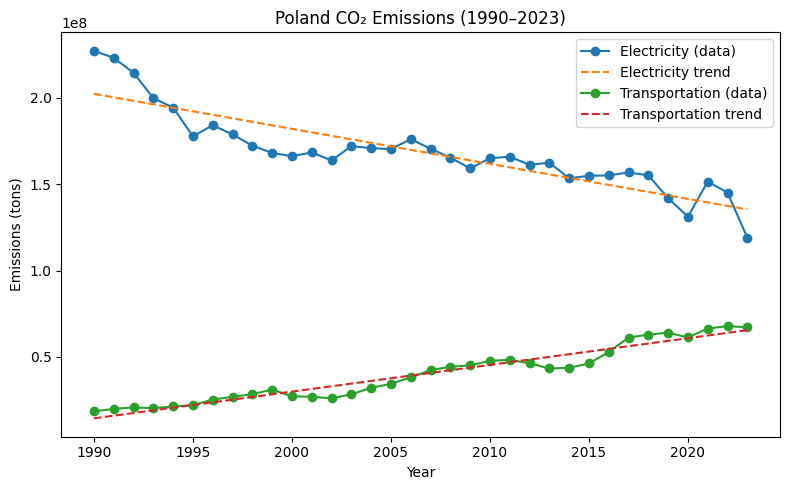

Portugal, Electricity: slope = -246842.89 per year (p = 0.001)
Portugal, Transportation: slope = 99944.11 per year (p = 0.026)


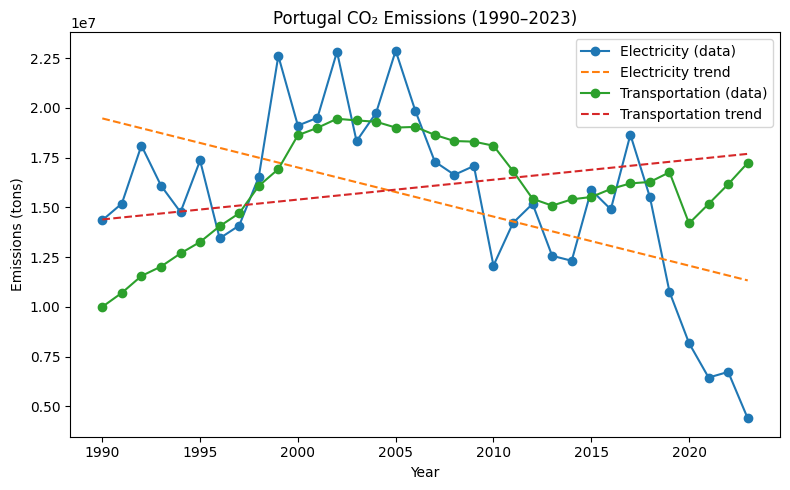

Romania, Electricity: slope = -1349353.25 per year (p = 0.000)
Romania, Transportation: slope = 368797.99 per year (p = 0.000)


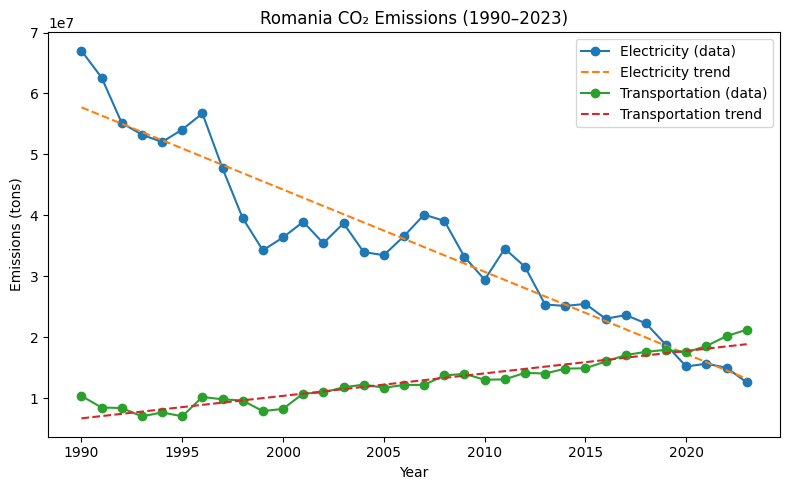

Slovakia, Electricity: slope = -243959.23 per year (p = 0.000)
Slovakia, Transportation: slope = 128066.16 per year (p = 0.000)


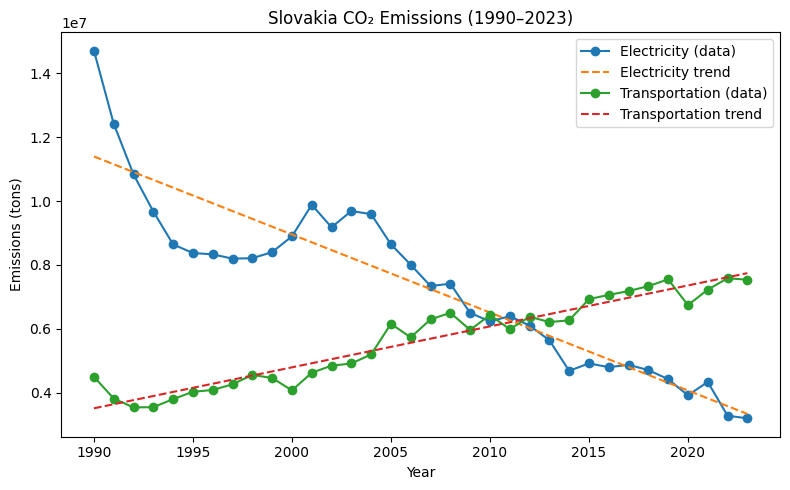

Slovenia, Electricity: slope = -49707.47 per year (p = 0.001)
Slovenia, Transportation: slope = 88741.64 per year (p = 0.000)


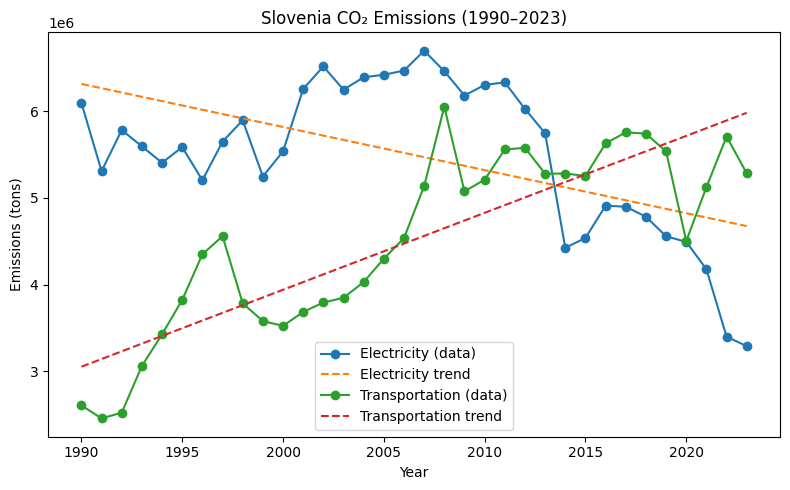

Spain, Electricity: slope = -983776.61 per year (p = 0.006)
Spain, Transportation: slope = 706149.89 per year (p = 0.000)


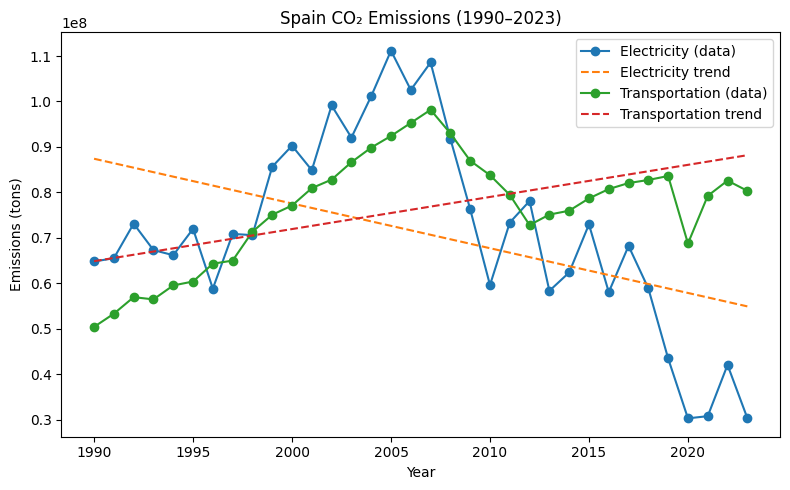

Sweden, Electricity: slope = -132026.79 per year (p = 0.000)
Sweden, Transportation: slope = -124846.30 per year (p = 0.000)


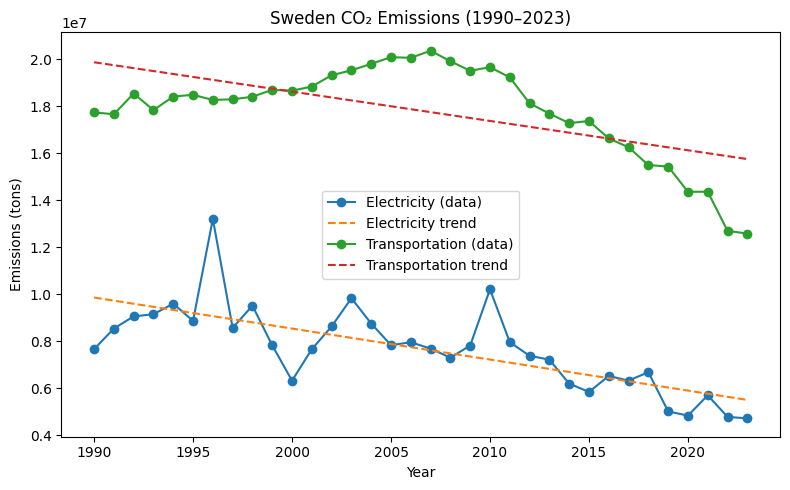

In [47]:
# plot emission trend for each eu country
excluded = ['EU-27', 'EU-25', 'EU-15']
countries = [c for c in emission['Country'].unique() if c.upper() not in excluded]

for country in countries:
    subset = emission[emission['Country'] == country]
    plt.figure(figsize=(8,5))

    for sector in subset['Sector'].unique():
        series = subset[subset['Sector'] == sector].sort_values('Year')

        # Plot actual emission data points
        plt.plot(series['Year'], series['Emission'], marker='o', label=f"{sector} (data)")

        # ---- Add linear trend line ----
        if len(series) >= 2:  # only fit if enough data points
            slope, intercept, r, p, stderr = linregress(series['Year'], series['Emission'])
            fit_line = intercept + slope * series['Year']
            plt.plot(series['Year'], fit_line, linestyle='--', label=f"{sector} trend")
            print(f"{country}, {sector}: slope = {slope:.2f} per year (p = {p:.3f})")

    plt.title(f"{country} CO₂ Emissions (1990–2023)")
    plt.xlabel("Year")
    plt.ylabel("Emissions (tons)")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
slopes = []
for (country, sector), grp in df.groupby(['Country', 'Sector']):
    grp2 = grp.groupby('Year')['Emissions'].sum().reset_index()
    if grp2['Year'].nunique() >= 5:
        slope, intercept, r, p, stderr = linregress(grp2['Year'], grp2['Emissions'])
        slopes.append({'Country': country, 'Sector': sector, 'Slope': slope})

slopes_df = pd.DataFrame(slopes)
pivot = slopes_df.pivot(index='Country', columns='Sector', values='Slope').dropna()

# Paired t-test for slope differences
tstat, pval = ttest_rel(pivot['Electricity'], pivot['Transportation'])
print(f"Paired t-test: t={tstat:.3f}, p={pval:.3f}")

# Part 4 Analysis

The “EU-27” aggregated observation in the dataset summarizes total emissions for the European Union. It allows direct analysis without summing across countries. By visualizing Electricity and Transportation emissions from 1990–2023, we can assess whether the ETS coincides with stronger reductions in ETS-covered activities. Linear trend lines fitted through each time series provide a clear depiction of direction and magnitude. Negative slopes indicate declining emissions, while positive slopes indicate continued growth.

At the EU-27 level, emissions from the Electricity sector declined sharply after 2005, while Transportation emissions remained relatively stable until the late 2010s. Linear regression results show a strongly negative slope for Electricity and a mild positive slope for Transportation. These contrasting patterns suggest that emissions fell more rapidly in ETS-covered activities.

At the country level, a downward trend, be it samll or large, can be observed in emissions from the electricity sector almost across the board except for countries like Poland